# Problem 3: Particle Filter for Robot Localization

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy.linalg

np.random.seed(123456)

## Simulation Setup

In [63]:
# Timesteps.
dt = 0.1
tf = 15
time = np.arange(0, tf+dt, dt)

# Ground-truth landmark positions.
xm = np.array([0, 0, 2, 8, 8, 2, 10, 10])
mr = len(xm) % 2

## Dynamics and Measurement Equations

In [64]:
def dynamics_model(
    xr: np.ndarray,
    v: float,
    omega: float,
) -> np.ndarray:
    """Filter dynamics model.

    NOTE: This dynamics model corresponds to Eq. (3) in the
          homework PDF document.

    Args:
        xr (np.ndarray): Robot state.
        v (float): Linear velocity command.
        omega (float): Angular velocity command.

    Returns:
        np.ndarray: Next robot state.
    """
    return np.array([xr[0] + dt * v * np.cos(xr[2]),
                     xr[1] + dt * v * np.sin(xr[2]),
                     xr[2] + dt * omega])


def measurement_model(
    xr: np.ndarray,
    xm: np.ndarray,
) -> np.ndarray:
    """Filter measurement model.

    NOTE: This measurement model corresponds to Eq. (4) in the
          homework PDF document.

    Args:
        xr (np.ndarray): Robot state.
        xm (np.ndarray): Landmark position.

    Returns:
        np.ndarray: Expected measurement.
    """
    px = xr[0]
    py = xr[1]
    th = xr[2]

    rot_mtx = np.array([[np.cos(th), np.sin(th)],
                        [-np.sin(th), np.cos(th)]])
    rot_mtx_tile = np.kron(np.eye(4, dtype=int),rot_mtx)
    robot_position_tile = np.tile(np.array([px, py]), (4,))

    return rot_mtx_tile @ (xm - robot_position_tile)

## Particle Filter Setup

In [65]:
# Ground-truth states (simulated).
x = np.zeros((3, len(time)))
x[:, 0] = [1, 1, 0]

# Mean and covariance of the prior state belief.
init_mu_std = 0.1
mu0 = [1, 1, 0] + np.random.multivariate_normal(np.zeros((3,)), init_mu_std*np.eye(3))
sigma0 = np.eye(3)

# Process and observation noise.
Q = (dt**2 * 0.1) * np.eye(3)
R = 0.25 * np.eye(8)

# Number of particles
num_particles = 1000

# Particle Filter Implementation

In [66]:
def gaussian_pdf(x, mu, sigma_inv):
    """
    Helper function to compute (unnormalized) likelihood of a point x
    for a Gaussian distribution with mean mu, and
    *inverse* covariance sigma_inv.
    """
    # note: don't compute the normalization factor because it doesn't matter.
    return np.exp(-(1/2)*np.dot(x-mu, sigma_inv @ (x-mu)))

In [ ]:
# unpack dimensions
T = len(time)
n = mu0.shape[0]

# containers for belief
mu_pf = np.zeros((n, T))
cov_pf = np.zeros((n, n, T))

# containers for particles
particles = np.zeros((n, num_particles))
updated_particles = np.zeros((n, num_particles))

# sample particles
particles = (mu0.reshape(n, 1) + scipy.linalg.sqrtm(sigma0)
                @ np.random.normal(size=(n, num_particles)))

# allocate weight vectors
weights = np.ones(num_particles) / num_particles
updated_weights = np.ones(num_particles)

# precompute meas. noise covariance inverse
R_inv = np.linalg.inv(R)

for i in range(0, len(time) - 1):
    ### Simulation.
    # True robot commands
    v = 1
    omega = np.sin(time[i])

    # True robot dynamics
    w_noise = np.random.multivariate_normal(np.zeros((3,)), Q)
    x[:, i+1] = dynamics_model(x[:, i], v, omega) + w_noise

    # True received measurement
    v_noise = np.random.multivariate_normal(np.zeros((8,)), R)
    y = measurement_model(x[:, i+1], xm) + v_noise

    ### Estimation.
    # sample particle noises
    W_particles = (np.linalg.cholesky(Q)
                    @ np.random.normal(size=(n, num_particles)))
    # print(W_particles.shape)

    ####################### Code starts here #######################
    # TODO: Implement Particle Filter's Predict and Update steps.
    # 1) Store the current belief's mean and covariance to 'mu_pf' and 'cov_pf'. Hint: Use functions 'np.sum()' and 'np.cov()'.
    # 2) Update each particle with its weight. Hint: Use functions 'dynamics_model()', 'measurement_model()' and 'gaussian_pdf()'.
    # Do not forget to add the process noise to each particle, i.e., 'W_particles'.
    # 3) Update and normalize the weights.
    # 4) Resample particles according to the updated particle weights. Hint: Use function 'np.random.choice()'.
    # 5) Reset weights to uniform.

    # Prediction Step
    mu_pf_i = np.mean(particles,axis=1) # (3,)
    cov_pf_i = np.cov(particles) # (3,3)

    mu_pf[:,i] = mu_pf_i
    cov_pf[:,:,i] = cov_pf_i


    weights_i = np.zeros(num_particles)
    X_bar_i = np.zeros((n, num_particles))
    for m in range(num_particles):
        xtm = dynamics_model(particles[:,m],v,omega) + W_particles[:,m]

        X_bar_i[:,m] = xtm
        wtm = gaussian_pdf(y,measurement_model(xtm,xm),R_inv) # p(zt|xt)
        weights_i[m] = wtm
    
    weights_i = weights_i/weights_i.sum()
    
    selected_indices = np.random.choice(X_bar_i.shape[1], size=num_particles, p=weights_i)
    particles = X_bar_i[:,selected_indices]
    ####################### Code ends here #######################

# store final belief
mu_pf[:, -1] = np.mean(particles, axis=1)
cov_pf[:, :, -1] = np.cov(particles)

# Plot Results

In [68]:
def plot_error_ellipse(ax, mean, cov):
    # Calculate the error ellipse parameters
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    order = eigenvalues.argsort()[::-1]
    eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
    angle = np.degrees(np.arctan2(*eigenvectors[:,0][::-1]))

    # Compute the radius of the ellipse to correspond to the desired confidence level
    chi2_val = 2.4477  # Corresponds to 95% conf. interval
    width, height = 2 * chi2_val * np.sqrt(eigenvalues)

    # Draw the ellipse
    ellipse = patches.Ellipse(mean, width, height, angle, edgecolor='red', fc='None', lw=2)
    ax.add_patch(ellipse)

### Plot Mean Estimates of Robot Pose Trajectory

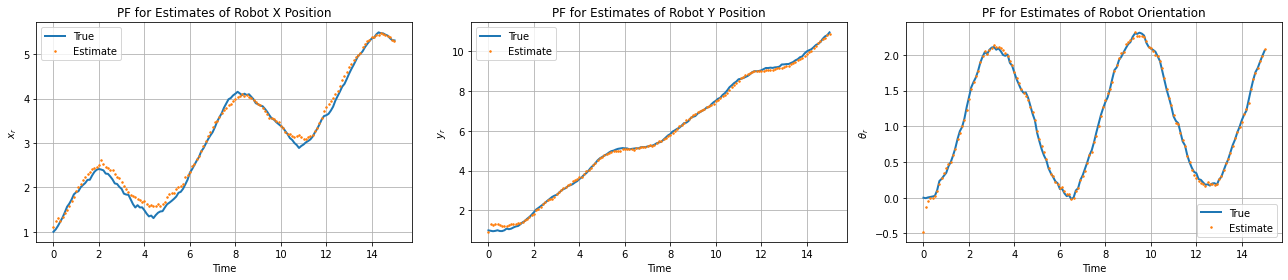

In [69]:
plt.figure(figsize=(18, 4))

# Subplot for px
plt.subplot(131)
plt.title('PF for Estimates of Robot X Position')
plt.plot(time, x[0, :], linewidth=2, label='True')
plt.plot(time, mu_pf[0, :], '.', markersize=3, label='Estimate')
plt.xlabel('Time')
plt.ylabel(r'$x_r$')
plt.legend()
plt.grid(True)

# Subplot for py
plt.subplot(132)
plt.title('PF for Estimates of Robot Y Position')
plt.plot(time, x[1, :], linewidth=2, label='True')
plt.plot(time, mu_pf[1, :], '.', markersize=3, label='Estimate')
plt.xlabel('Time')
plt.ylabel(r'$y_r$')
plt.legend()
plt.grid(True)


# Subplot for theta
plt.subplot(133)
plt.title('PF for Estimates of Robot Orientation')
plt.plot(time, x[2, :], linewidth=2, label='True')
plt.plot(time, mu_pf[2, :], '.', markersize=3, label='Estimate')
plt.xlabel('Time')
plt.ylabel(r'$\theta_r$')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Plot Error Ellipses Along Trajectory

/var/folders/pw/pb93h1ws5dx02zs9x_45hk4w0000gn/T/ipykernel_17843/3806365674.py:13: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ellipse = patches.Ellipse(mean, width, height, angle, edgecolor='red', fc='None', lw=2)


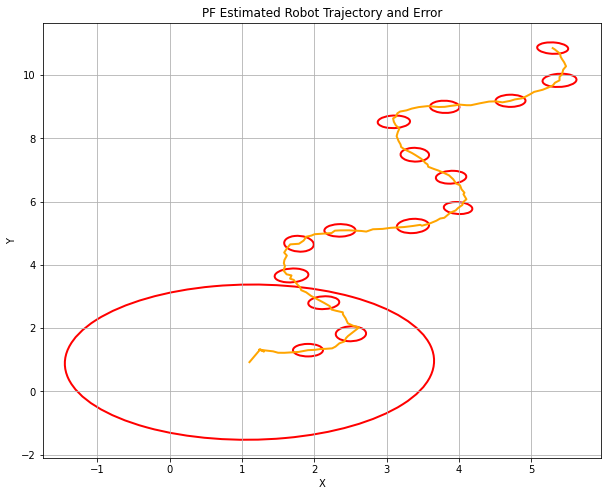

In [70]:
plt.figure(figsize=(10, 8))
plt.title('PF Estimated Robot Trajectory and Error')
plt.plot(mu_pf[0, :], mu_pf[1, :], color='orange', linewidth=2)
for i in range(0, len(time), 10):
    plot_error_ellipse(plt.gca(), mu_pf[:2, i], cov_pf[:2, :2, i])
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.show()

### Plot Robot Trajectory in X-Y Space

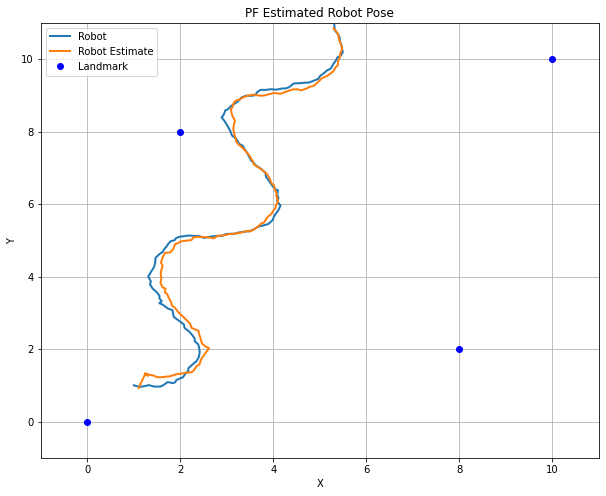

In [71]:
plt.figure(figsize=(10, 8))
plt.title('PF Estimated Robot Pose')
plt.plot(x[0, :], x[1, :], linewidth=2, label='Robot')
plt.plot(mu_pf[0, :], mu_pf[1, :], linewidth=2, label='Robot Estimate')
plt.plot(xm.reshape((4,2))[:, 0], xm.reshape((4,2))[:, 1], 'b.', markersize=12, label='Landmark')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.xlim([-1, 11])
plt.ylim([-1, 11])
plt.grid(True)
plt.show()